## **Сессионное задание. Помазкин М.А.**

### Трек 1. Обучение агента в классической среде Acrobot-v1

1. Сравнение двух алгоритмов на Acrobot-v1: A2C vs PPO (одинаковая архитектура сети, схожие шаги обучения).

2. Влияние архитектуры сети для PPO: маленькая vs большая сеть при фиксированных остальных гиперпараметрах.

In [1]:
!pip uninstall -y stable-baselines3 shimmy gymnasium > /dev/null 2>&1

# 2. Ставим ПОСЛЕДНЮЮ версию SB3 прямо из GitHub (там уже есть фиксы для NumPy 2.0)
!pip install -q git+https://github.com/DLR-RM/stable-baselines3@master

# 3. Ставим совместимый gymnasium и shimmy
!pip install -q "gymnasium[all]" shimmy>=2.0.0 matplotlib pandas

# 4. Импорты
import os
import time
import random
import warnings
import gymnasium as gym
import numpy as np
import torch
import pandas as pd
from stable_baselines3 import A2C, PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecVideoRecorder
from stable_baselines3.common.monitor import Monitor
from typing import Callable, Dict, Any
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.results_plotter import load_results, ts2xy

# 5. Игнорируем предупреждения совместимости (они не влияют на работу)
warnings.filterwarnings("ignore")
os.environ["GYMNASIUM_NO_WARNINGS"] = "1"


import matplotlib.pyplot as plt

print("Библиотеки загружены")

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.1.2 requires gym<=0.25.2, which is not installed.
Библиотеки загружены


In [2]:
# 2.  Константы и настройка воспроизводимости
SEED = 123
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

ENV_ID = "Acrobot-v1"
TOTAL_TIMESTEPS = 100_000
EVAL_EPISODES = 20

# Пути для сохранения
LOG_DIR = "./rl_logs_acrobot"
VIDEO_DIR = "./rl_videos_acrobot"
os.makedirs(LOG_DIR, exist_ok=True)
os.makedirs(VIDEO_DIR, exist_ok=True)

# Фиксируем ВСЕ три генератора случайных чисел для воспроизводимости
random.seed(SEED)           # Python random module
np.random.seed(SEED)        # NumPy random
torch.manual_seed(SEED)     # PyTorch (CPU + CUDA)

# Для CPU тоже нужны детерминированные операции
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print(f" Seed установлен: {SEED}")
print(f" Окружение: {ENV_ID}")
print(f" Всего timesteps: {TOTAL_TIMESTEPS:,}")
print(f" LOG_DIR: {LOG_DIR}")
print(f" VIDEO_DIR: {VIDEO_DIR}")

 Seed установлен: 123
 Окружение: Acrobot-v1
 Всего timesteps: 100,000
 LOG_DIR: ./rl_logs_acrobot
 VIDEO_DIR: ./rl_videos_acrobot


In [3]:
# 3. Вспомогательные функции
def make_env(env_id: str, seed: int, log_dir: str) -> Callable:
    """Фабрика для создания Monitor-окружения с фиксированным сидом."""
    def _init():
        env = gym.make(env_id)
        env.reset(seed=seed)
        env.action_space.seed(seed)
        env.observation_space.seed(seed)
        env = Monitor(env, log_dir, allow_early_resets=True)
        return env
    return _init

class RewardCallback(BaseCallback):

    def __init__(self, log_dir: str, verbose: int = 0):
        super().__init__(verbose)
        self.log_dir = log_dir

    def _on_step(self) -> bool:
        return True

def plot_results_single(log_dir: str, title: str, window: int = 30, color=None):

    try:
        results = load_results(log_dir)
        x, y = ts2xy(results, "episodes")

        if len(y) == 0:
            print(f"⚠ Нет данных для {log_dir}")
            return

        # Скользящее среднее
        if len(y) >= window:
            y_smooth = np.convolve(y, np.ones(window) / window, mode="valid")
            x_smooth = x[window - 1:]
        else:
            y_smooth = y
            x_smooth = x

        plt.plot(x_smooth, y_smooth, label=title, linewidth=2, color=color, alpha=0.8)
    except Exception as e:
        print(f"Ошибка при чтении {log_dir}: {e}")

print("Вспомогательные функции определены")


Вспомогательные функции определены


In [4]:
# 4.Функции оценки и видео
def evaluate_agent(env_id: str, model, n_episodes: int = 20, seed: int = 123) -> Dict[str, Any]:
    """
    Оценка обученного агента на n_episodes эпизодов.

    Returns:
        dict с mean_reward, std_reward, all_rewards
    """
    env = gym.make(env_id, render_mode=None)

    rewards = []
    for ep in range(n_episodes):
        obs, _ = env.reset(seed=seed + ep)
        terminated, truncated = False, False
        ep_reward = 0.0

        while not (terminated or truncated):
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, _ = env.step(action)
            ep_reward += reward

        rewards.append(ep_reward)

    env.close()

    return {
        "mean_reward": float(np.mean(rewards)),
        "std_reward": float(np.std(rewards)),
        "min_reward": float(np.min(rewards)),
        "max_reward": float(np.max(rewards)),
        "all_rewards": rewards,
    }


def record_video(env_id: str, model, video_path: str, n_episodes: int = 1,
                 seed: int = 999, episode_length: int = 500):
    """
    Запись видео работы финального агента.

    Args:
        env_id: ID окружения Gymnasium
        model: обученная модель SB3
        video_path: путь для сохранения видео
        n_episodes: количество эпизодов для записи
        seed: seed для воспроизводимости
        episode_length: максимальная длина эпизода
    """
    def _make_env():
        env = gym.make(env_id, render_mode="rgb_array")
        env.reset(seed=seed)
        env.action_space.seed(seed)
        env.observation_space.seed(seed)
        return env

    vec_env = DummyVecEnv([_make_env])
    vec_env = VecVideoRecorder(
        vec_env,
        video_path,
        record_video_trigger=lambda x: x == 0,
        video_length=episode_length,
        name_prefix="acrobot-agent",
    )

    obs = vec_env.reset()
    for _ in range(episode_length * n_episodes):
        action, _ = model.predict(obs, deterministic=True)
        obs, _, dones, _ = vec_env.step(action)
        if dones[0]:
            break  # остановка после первого успешного эпизода

    vec_env.close()
    print(f" Видео записано в {video_path}")

print("Функции оценки и записи видео определены")

Функции оценки и записи видео определены


In [5]:
# 5. Эксперимент 1 — A2C
print("ЭКСПЕРИМЕНТ 1: Сравнение алгоритмов A2C vs PPO на Acrobot-v1")
print("Гипотеза: PPO показывает более стабильное обучение чем A2C")

log_dir_a2c = os.path.join(LOG_DIR, "exp1_a2c")
os.makedirs(log_dir_a2c, exist_ok=True)

# Создаём окружение
env_a2c = DummyVecEnv([make_env(ENV_ID, SEED, log_dir_a2c)])

# Создаём модель A2C с одинаковой архитектурой
a2c_model = A2C(
    policy="MlpPolicy",
    env=env_a2c,
    learning_rate=7e-4,
    n_steps=5,
    gamma=0.99,
    verbose=1,
    seed=SEED,
    policy_kwargs=dict(net_arch=[64, 64]),
)

print("\n Обучение A2C (net_arch=[64, 64])...")
start_time = time.time()
a2c_model.learn(total_timesteps=TOTAL_TIMESTEPS)
a2c_time = time.time() - start_time

print(f" A2C обучен за {a2c_time:.1f} сек ({a2c_time/60:.1f} мин)")

# Сохранение
a2c_model.save(os.path.join(LOG_DIR, "a2c_acrobot.zip"))
env_a2c.close()

ЭКСПЕРИМЕНТ 1: Сравнение алгоритмов A2C vs PPO на Acrobot-v1
Гипотеза: PPO показывает более стабильное обучение чем A2C
Using cpu device

 Обучение A2C (net_arch=[64, 64])...
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 500      |
|    ep_rew_mean        | -500     |
| time/                 |          |
|    fps                | 545      |
|    iterations         | 100      |
|    time_elapsed       | 0        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -1.08    |
|    explained_variance | 0.101    |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | -2.91    |
|    value_loss         | 7.77     |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 500      |
|    ep_rew_mean        | -500     |
| time/                 |          |
|    fps   

In [6]:
# 6.Эксперимент 1 — PPO
log_dir_ppo = os.path.join(LOG_DIR, "exp1_ppo")
os.makedirs(log_dir_ppo, exist_ok=True)

# Создаём окружение
env_ppo = DummyVecEnv([make_env(ENV_ID, SEED, log_dir_ppo)])

# Создаём модель PPO с той же архитектурой
ppo_model = PPO(
    policy="MlpPolicy",
    env=env_ppo,
    learning_rate=3e-4,
    n_steps=2048,
    batch_size=64,
    n_epochs=10,
    gamma=0.99,
    verbose=1,
    seed=SEED,
    policy_kwargs=dict(net_arch=[64, 64]),
)

print("\n🚀 Обучение PPO (net_arch=[64, 64])...")
start_time = time.time()
ppo_model.learn(total_timesteps=TOTAL_TIMESTEPS, progress_bar=True)
ppo_time = time.time() - start_time

print(f"✓ PPO обучен за {ppo_time:.1f} сек ({ppo_time/60:.1f} мин)")

# Сохранение
ppo_model.save(os.path.join(LOG_DIR, "ppo_acrobot.zip"))
env_ppo.close()

Output()

Using cpu device

🚀 Обучение PPO (net_arch=[64, 64])...
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 500      |
|    ep_rew_mean     | -500     |
| time/              |          |
|    fps             | 558      |
|    iterations      | 1        |
|    time_elapsed    | 3        |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 500          |
|    ep_rew_mean          | -500         |
| time/                   |              |
|    fps                  | 313          |
|    iterations           | 2            |
|    time_elapsed         | 13           |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0057525085 |
|    clip_fraction        | 0.0277       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.09        |
| 

✓ PPO обучен за 191.5 сек (3.2 мин)


✓ График сохранён: ./rl_logs_acrobot/exp1_a2c_vs_ppo_reward.png


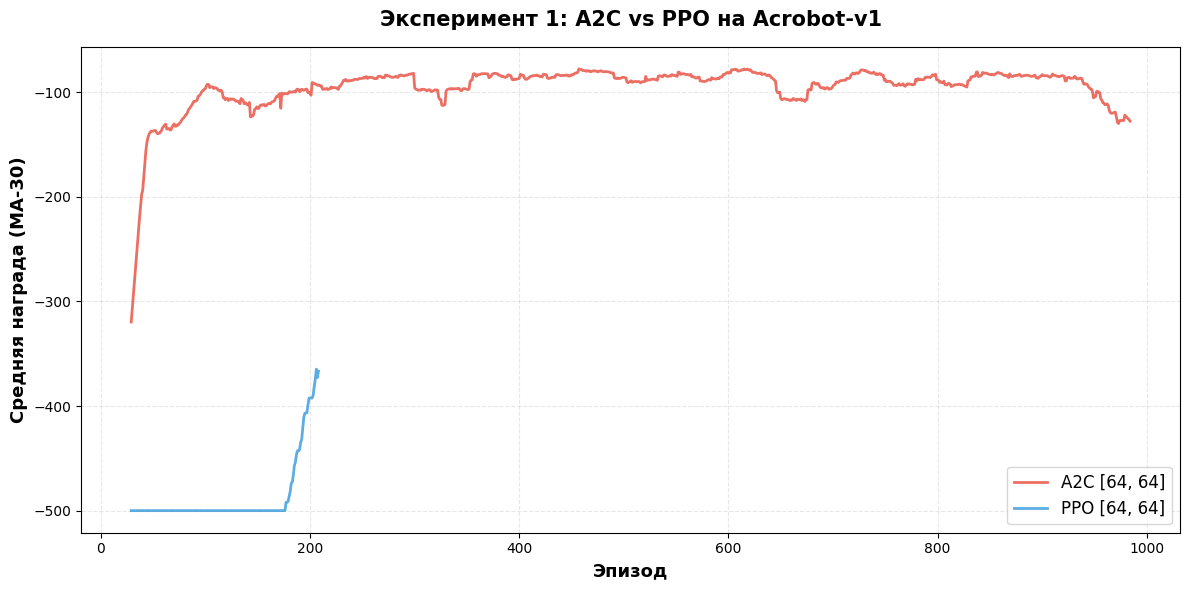

In [7]:
# 7.График Эксперимента 1
# ============================================
plt.figure(figsize=(12, 6))
plot_results_single(log_dir_a2c, title="A2C [64, 64]", window=30, color='#e74c3c')
plot_results_single(log_dir_ppo, title="PPO [64, 64]", window=30, color='#3498db')

plt.xlabel("Эпизод", fontsize=13, fontweight='bold')
plt.ylabel("Средняя награда (MA-30)", fontsize=13, fontweight='bold')
plt.title("Эксперимент 1: A2C vs PPO на Acrobot-v1", fontsize=15, fontweight='bold', pad=15)
plt.legend(fontsize=12, loc='lower right')
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()

# Сохранение
save_path = os.path.join(LOG_DIR, "exp1_a2c_vs_ppo_reward.png")
plt.savefig(save_path, dpi=150, bbox_inches='tight')
print(f"✓ График сохранён: {save_path}")
plt.show()

In [8]:
# 8.Оценка моделей из Эксперимента 1
print("\n📊 Оценка производительности агентов...")
eval_a2c = evaluate_agent(ENV_ID, a2c_model, n_episodes=EVAL_EPISODES, seed=SEED)
eval_ppo = evaluate_agent(ENV_ID, ppo_model, n_episodes=EVAL_EPISODES, seed=SEED)

print("\n" + "=" * 80)
print("РЕЗУЛЬТАТЫ ЭКСПЕРИМЕНТА 1: A2C vs PPO")
print("=" * 80)
print(f"{'Алгоритм':<15} {'Mean ± Std':<25} {'Min':<12} {'Max':<12}")
print("-" * 80)
print(f"{'A2C [64,64]':<15} {eval_a2c['mean_reward']:>8.2f} ± {eval_a2c['std_reward']:<8.2f}    "
      f"{eval_a2c['min_reward']:>8.2f}    {eval_a2c['max_reward']:>8.2f}")
print(f"{'PPO [64,64]':<15} {eval_ppo['mean_reward']:>8.2f} ± {eval_ppo['std_reward']:<8.2f}    "
      f"{eval_ppo['min_reward']:>8.2f}    {eval_ppo['max_reward']:>8.2f}")
print("=" * 80)

# Определяем победителя
if eval_ppo['mean_reward'] > eval_a2c['mean_reward']:
    diff = eval_ppo['mean_reward'] - eval_a2c['mean_reward']
    print(f" PPO превосходит A2C на {diff:.2f} в среднем")
else:
    diff = eval_a2c['mean_reward'] - eval_ppo['mean_reward']
    print(f"A2C превосходит PPO на {diff:.2f} в среднем")


📊 Оценка производительности агентов...

РЕЗУЛЬТАТЫ ЭКСПЕРИМЕНТА 1: A2C vs PPO
Алгоритм        Mean ± Std                Min          Max         
--------------------------------------------------------------------------------
A2C [64,64]      -500.00 ± 0.00         -500.00     -500.00
PPO [64,64]      -218.35 ± 102.99       -500.00      -99.00
 PPO превосходит A2C на 281.65 в среднем


In [9]:
#  9: Эксперимент 2 — PPO малая сеть
print("\n" + "=" * 70)
print("ЭКСПЕРИМЕНТ 2: Влияние размера нейросети на производительность PPO")
print("Гипотеза: Большая сеть обучается медленнее, но достигает лучшего результата")
print("=" * 70)

log_dir_ppo_small = os.path.join(LOG_DIR, "exp2_ppo_small")
os.makedirs(log_dir_ppo_small, exist_ok=True)

# Окружение
env_small = DummyVecEnv([make_env(ENV_ID, SEED, log_dir_ppo_small)])

# Модель PPO с маленькой сетью
ppo_small = PPO(
    policy="MlpPolicy",
    env=env_small,
    learning_rate=3e-4,
    n_steps=2048,
    batch_size=64,
    n_epochs=10,
    gamma=0.99,
    verbose=1,
    seed=SEED,
    policy_kwargs=dict(net_arch=[32, 32]),
)

print("\n🚀 Обучение PPO small (net_arch=[32, 32])...")
start_time = time.time()
ppo_small.learn(total_timesteps=TOTAL_TIMESTEPS, progress_bar=True)
ppo_small_time = time.time() - start_time

print(f"✓ PPO small обучен за {ppo_small_time:.1f} сек ({ppo_small_time/60:.1f} мин)")

# Сохранение
ppo_small.save(os.path.join(LOG_DIR, "ppo_acrobot_small.zip"))
env_small.close()

Output()


ЭКСПЕРИМЕНТ 2: Влияние размера нейросети на производительность PPO
Гипотеза: Большая сеть обучается медленнее, но достигает лучшего результата
Using cpu device

🚀 Обучение PPO small (net_arch=[32, 32])...
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 500      |
|    ep_rew_mean     | -500     |
| time/              |          |
|    fps             | 901      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 500          |
|    ep_rew_mean          | -500         |
| time/                   |              |
|    fps                  | 708          |
|    iterations           | 2            |
|    time_elapsed         | 5            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl          

✓ PPO small обучен за 169.4 сек (2.8 мин)


In [10]:
# 10. Эксперимент 2 — PPO большая сеть
# ============================================
log_dir_ppo_big = os.path.join(LOG_DIR, "exp2_ppo_big")
os.makedirs(log_dir_ppo_big, exist_ok=True)

# Окружение
env_big = DummyVecEnv([make_env(ENV_ID, SEED, log_dir_ppo_big)])

# Модель PPO с большой сетью
ppo_big = PPO(
    policy="MlpPolicy",
    env=env_big,
    learning_rate=3e-4,
    n_steps=2048,
    batch_size=64,
    n_epochs=10,
    gamma=0.99,
    verbose=1,
    seed=SEED,
    policy_kwargs=dict(net_arch=[256, 256]),
)

print("\n Обучение PPO big (net_arch=[256, 256])...")
start_time = time.time()
ppo_big.learn(total_timesteps=TOTAL_TIMESTEPS, progress_bar=True)
ppo_big_time = time.time() - start_time

print(f"✓ PPO big обучен за {ppo_big_time:.1f} сек ({ppo_big_time/60:.1f} мин)")

# Сохранение
ppo_big.save(os.path.join(LOG_DIR, "ppo_acrobot_big.zip"))
env_big.close()

Output()

Using cpu device

 Обучение PPO big (net_arch=[256, 256])...
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 498      |
|    ep_rew_mean     | -498     |
| time/              |          |
|    fps             | 991      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 499          |
|    ep_rew_mean          | -499         |
| time/                   |              |
|    fps                  | 666          |
|    iterations           | 2            |
|    time_elapsed         | 6            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0070224125 |
|    clip_fraction        | 0.0498       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.09       

✓ PPO big обучен за 218.3 сек (3.6 мин)


✓ График сохранён: ./rl_logs_acrobot/exp2_architecture_reward.png


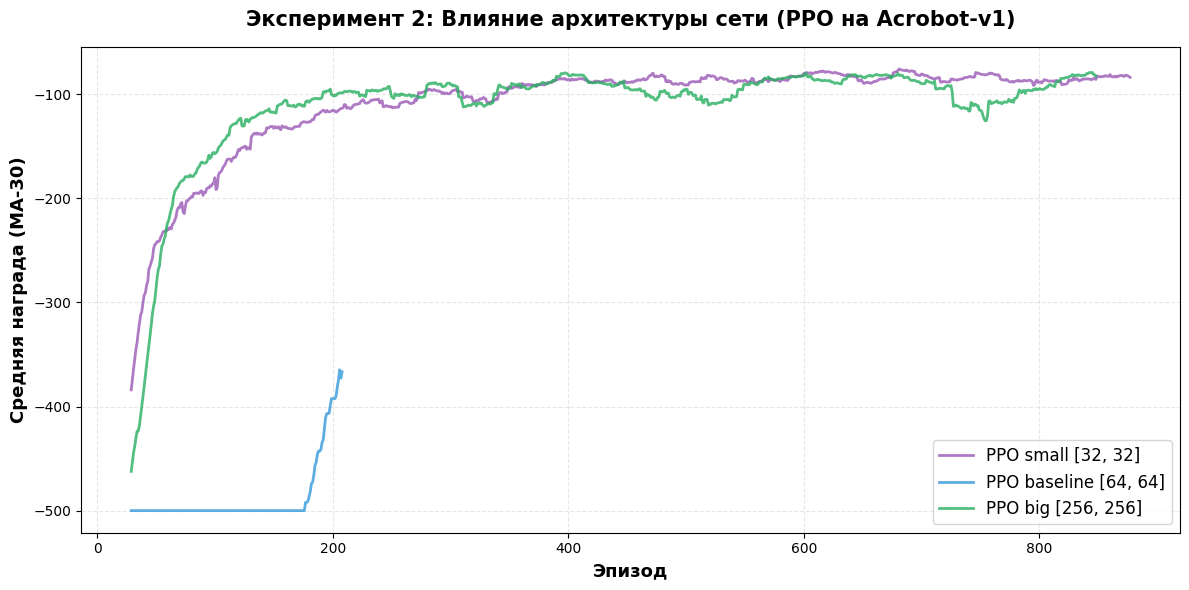

In [11]:
# 11. График Эксперимента 2
plt.figure(figsize=(12, 6))
plot_results_single(log_dir_ppo_small, title="PPO small [32, 32]", window=30, color='#9b59b6')
plot_results_single(log_dir_ppo, title="PPO baseline [64, 64]", window=30, color='#3498db')
plot_results_single(log_dir_ppo_big, title="PPO big [256, 256]", window=30, color='#27ae60')

plt.xlabel("Эпизод", fontsize=13, fontweight='bold')
plt.ylabel("Средняя награда (MA-30)", fontsize=13, fontweight='bold')
plt.title("Эксперимент 2: Влияние архитектуры сети (PPO на Acrobot-v1)",
          fontsize=15, fontweight='bold', pad=15)
plt.legend(fontsize=12, loc='lower right')
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()

# Сохранение
save_path = os.path.join(LOG_DIR, "exp2_architecture_reward.png")
plt.savefig(save_path, dpi=150, bbox_inches='tight')
print(f"✓ График сохранён: {save_path}")
plt.show()

In [12]:
#  12. Оценка моделей из Эксперимента 2
print("\n Оценка производительности разных архитектур...")
eval_ppo_small = evaluate_agent(ENV_ID, ppo_small, n_episodes=EVAL_EPISODES, seed=SEED)
eval_ppo_big = evaluate_agent(ENV_ID, ppo_big, n_episodes=EVAL_EPISODES, seed=SEED)

print("\n" + "=" * 80)
print("РЕЗУЛЬТАТЫ ЭКСПЕРИМЕНТА 2: Влияние архитектуры сети")
print("=" * 80)
print(f"{'Архитектура':<20} {'Mean ± Std':<25} {'Min':<12} {'Max':<12}")
print("-" * 80)
print(f"{'PPO [32,32]':<20} {eval_ppo_small['mean_reward']:>8.2f} ± {eval_ppo_small['std_reward']:<8.2f}    "
      f"{eval_ppo_small['min_reward']:>8.2f}    {eval_ppo_small['max_reward']:>8.2f}")
print(f"{'PPO [64,64]':<20} {eval_ppo['mean_reward']:>8.2f} ± {eval_ppo['std_reward']:<8.2f}    "
      f"{eval_ppo['min_reward']:>8.2f}    {eval_ppo['max_reward']:>8.2f}")
print(f"{'PPO [256,256]':<20} {eval_ppo_big['mean_reward']:>8.2f} ± {eval_ppo_big['std_reward']:<8.2f}    "
      f"{eval_ppo_big['min_reward']:>8.2f}    {eval_ppo_big['max_reward']:>8.2f}")
print("=" * 80)

# Анализ
best_arch = max(
    [("small", eval_ppo_small), ("baseline", eval_ppo), ("big", eval_ppo_big)],
    key=lambda x: x[1]['mean_reward']
)
print(f" Лучшая архитектура: {best_arch[0].upper()} "
      f"(mean_reward={best_arch[1]['mean_reward']:.2f})")


 Оценка производительности разных архитектур...

РЕЗУЛЬТАТЫ ЭКСПЕРИМЕНТА 2: Влияние архитектуры сети
Архитектура          Mean ± Std                Min          Max         
--------------------------------------------------------------------------------
PPO [32,32]            -86.35 ± 16.89        -150.00      -71.00
PPO [64,64]           -218.35 ± 102.99       -500.00      -99.00
PPO [256,256]          -92.40 ± 29.09        -179.00      -65.00
 Лучшая архитектура: SMALL (mean_reward=-86.35)


In [13]:
# 13. Запись видео лучшего агента
print("\n Запись видео лучшего агента...")

# Выбираем лучшую модель из всех экспериментов
all_models = [
    ("A2C [64,64]", a2c_model, eval_a2c),
    ("PPO [64,64]", ppo_model, eval_ppo),
    ("PPO [32,32]", ppo_small, eval_ppo_small),
    ("PPO [256,256]", ppo_big, eval_ppo_big),
]

best_name, best_model, best_eval = max(all_models, key=lambda x: x[2]['mean_reward'])
print(f" Выбрана модель: {best_name}")
print(f" Mean reward: {best_eval['mean_reward']:.2f} ± {best_eval['std_reward']:.2f}")

# Записываем видео
record_video(ENV_ID, best_model, VIDEO_DIR, n_episodes=1, seed=SEED)
print(" Видео успешно записано!")


 Запись видео лучшего агента...
 Выбрана модель: PPO [32,32]
 Mean reward: -86.35 ± 16.89
Moviepy - Building video /content/rl_videos_acrobot/acrobot-agent-step-0-to-step-500.mp4.
Moviepy - Writing video /content/rl_videos_acrobot/acrobot-agent-step-0-to-step-500.mp4



Moviepy - Done !
Moviepy - video ready /content/rl_videos_acrobot/acrobot-agent-step-0-to-step-500.mp4
 Видео записано в ./rl_videos_acrobot
 Видео успешно записано!


In [14]:
# Ячейка 14: Экспорт requirements и финального отчёта
# ============================================
# Сохранение зависимостей
!pip freeze > requirements_acrobot.txt
print("requirements_acrobot.txt сохранён")

# Сохранение параметров экспериментов
summary = f"""
{'='*80}
ОТЧЁТ ПО ЭКСПЕРИМЕНТАМ С ACROBOT-V1
{'='*80}

ПАРАМЕТРЫ:
----------
- Seed: {SEED}
- Environment: {ENV_ID}
- Total timesteps: {TOTAL_TIMESTEPS:,}
- Evaluation episodes: {EVAL_EPISODES}

ЭКСПЕРИМЕНТ 1: A2C vs PPO
--------------------------
Цель: Сравнить два policy gradient алгоритма
Архитектура: net_arch=[64, 64] для обоих

Результаты:
  A2C [64,64]: {eval_a2c['mean_reward']:.2f} ± {eval_a2c['std_reward']:.2f}
  PPO [64,64]: {eval_ppo['mean_reward']:.2f} ± {eval_ppo['std_reward']:.2f}

ЭКСПЕРИМЕНТ 2: Архитектура сети (PPO)
--------------------------------------
Цель: Определить влияние размера сети на производительность
Гиперпараметры PPO: одинаковые для всех вариантов

Результаты:
  PPO [32,32]:   {eval_ppo_small['mean_reward']:.2f} ± {eval_ppo_small['std_reward']:.2f}
  PPO [64,64]:   {eval_ppo['mean_reward']:.2f} ± {eval_ppo['std_reward']:.2f}
  PPO [256,256]: {eval_ppo_big['mean_reward']:.2f} ± {eval_ppo_big['std_reward']:.2f}

ЛУЧШАЯ МОДЕЛЬ: {best_name}
{'='*80}

ВОСПРОИЗВОДИМОСТЬ:
------------------
1. Установить зависимости: pip install -r requirements_acrobot.txt
2. Использовать seed={SEED}
3. Запустить на CPU (для полной детерминированности)

ФАЙЛЫ:
------
- Модели: {LOG_DIR}/*.zip
- Графики: {LOG_DIR}/*.png
- Логи: {LOG_DIR}/exp*/*.csv
- Видео: {VIDEO_DIR}/*.mp4
- Зависимости: requirements_acrobot.txt
"""

# Сохранение отчёта
report_path = os.path.join(LOG_DIR, "experiment_report.txt")
with open(report_path, "w", encoding="utf-8") as f:
    f.write(summary)

print(f"✓ Отчёт сохранён: {report_path}")
print("\n" + summary)

print("\n" + "="*80)
print(" ВСЕ ЭКСПЕРИМЕНТЫ ЗАВЕРШЕНЫ!")
print("="*80)
print(f" Все файлы находятся в: {LOG_DIR}")
print(f" Видео находится в: {VIDEO_DIR}")

✓ requirements_acrobot.txt сохранён
✓ Отчёт сохранён: ./rl_logs_acrobot/experiment_report.txt


ОТЧЁТ ПО ЭКСПЕРИМЕНТАМ С ACROBOT-V1

ПАРАМЕТРЫ:
----------
- Seed: 123
- Environment: Acrobot-v1
- Total timesteps: 100,000
- Evaluation episodes: 20

ЭКСПЕРИМЕНТ 1: A2C vs PPO
--------------------------
Цель: Сравнить два policy gradient алгоритма
Архитектура: net_arch=[64, 64] для обоих

Результаты:
  A2C [64,64]: -500.00 ± 0.00
  PPO [64,64]: -218.35 ± 102.99

ЭКСПЕРИМЕНТ 2: Архитектура сети (PPO)
--------------------------------------
Цель: Определить влияние размера сети на производительность
Гиперпараметры PPO: одинаковые для всех вариантов

Результаты:
  PPO [32,32]:   -86.35 ± 16.89
  PPO [64,64]:   -218.35 ± 102.99
  PPO [256,256]: -92.40 ± 29.09

ЛУЧШАЯ МОДЕЛЬ: PPO [32,32]

ВОСПРОИЗВОДИМОСТЬ:
------------------
1. Установить зависимости: pip install -r requirements_acrobot.txt
2. Использовать seed=123
3. Запустить на CPU (для полной детерминированности)

ФАЙЛЫ:
------
- Модели: ./r